In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/youtube8m-2019/sample_submission.csv
/kaggle/input/youtube8m-2019/vocabulary.csv
/kaggle/input/youtube8m-2019/frame-sample.zip
/kaggle/input/youtube8m-2019/validate-sample.zip


In [3]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3 MB 19 kB/s s eta 0:00:01  |▌                               | 6.0 MB 4.0 MB/s eta 0:01:42     |████████▎                       | 106.2 MB 46.5 MB/s eta 0:00:07     |███████████████▌                | 199.4 MB 18.6 MB/s eta 0:00:12     |█████████████████▊              | 228.2 MB 41.0 MB/s eta 0:00:05     |████████████████████▌           | 264.4 MB 42.4 MB/s eta 0:00:04     |██████████████████████▉         | 294.8 MB 42.4 MB/s eta 0:00:03     |█████████████████████████▎      | 325.3 MB 35.9 MB/s eta 0:00:03     |███████████████████████████████▎| 403.1 MB 71.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 37.8 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 4.7 MB/s  eta 0:00:01
     |████████████████████████████████| 503 kB 55.3 MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7538 sha256=d4b0f49105def136609825c0081939b31613d09544010e5dd330cc8c93c2f6d1
  Stored in directory: /

In [4]:
!unzip /kaggle/input/youtube8m-2019/frame-sample.zip -d /kaggle/working
!unzip /kaggle/input/youtube8m-2019/validate-sample.zip -d /kaggle/working

Archive:  /kaggle/input/youtube8m-2019/frame-sample.zip
   creating: /kaggle/working/frame/
  inflating: /kaggle/working/frame/train01.tfrecord  
  inflating: /kaggle/working/frame/train00.tfrecord  
Archive:  /kaggle/input/youtube8m-2019/validate-sample.zip
   creating: /kaggle/working/validate/
  inflating: /kaggle/working/validate/validate01.tfrecord  
  inflating: /kaggle/working/validate/validate00.tfrecord  


In [5]:
import csv
import warnings
from subprocess import check_output

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import YouTubeVideo
from wordcloud import WordCloud, STOPWORDS

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [6]:
frame_lvl_record = '/kaggle/working/frame/train00.tfrecord'

print(os.listdir('/kaggle/working/frame'))
print(os.listdir('/kaggle/working/validate'))

['train00.tfrecord', 'train01.tfrecord']
['validate00.tfrecord', 'validate01.tfrecord']


In [7]:
sub = pd.read_csv('/kaggle/input/youtube8m-2019/sample_submission.csv')
sub.head()

,Class,Segments
0,3,002G:35 002G:40 002G:60
1,7,002G:35 002G:40 002G:60
2,8,002G:35 002G:40 002G:60
3,11,002G:35 002G:40 002G:60
4,12,002G:35 002G:40 002G:60


In [8]:
# 動画のidとラベルを取得
vid_ids = []
labels = []

for example in tf.compat.v1.python_io.tf_record_iterator(frame_lvl_record):
    tf_example = tf.train.Example.FromString(example)
    vid_ids.append(tf_example.features.feature['id']
                   .bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)

print('Number of videos in this tfrecord: ', len(vid_ids))
print ('Number of labels in this tfrecord: ', len (labels))
print('Picking a youtube video id:', vid_ids[15])

Number of videos in this tfrecord:  1015
Number of labels in this tfrecord:  1015
Picking a youtube video id: FF00


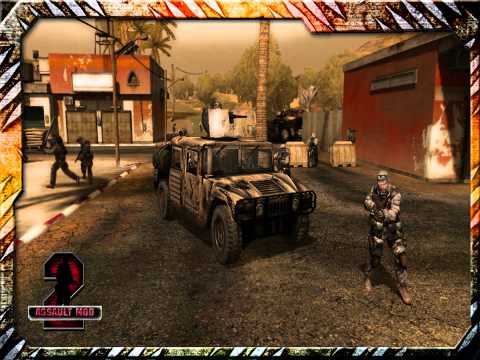

In [9]:
YouTubeVideo('UzXQaOLQVCU')

In [10]:
# 最初の動画を読み込む
feat_rgb = []
feat_audio = []

for example in tf.compat.v1.python_io.tf_record_iterator(frame_lvl_record):  
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.compat.v1.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.compat.v1.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.compat.v1.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    
    feat_audio.append(audio_frame)
    feat_rgb.append(rgb_frame)
    break

In [12]:
print('The first video has %d frames' %len(feat_rgb[0]))

The first video has 234 frames


In [15]:
vocabulary = pd.read_csv('/kaggle/input/youtube8m-2019/vocabulary.csv')
vocabulary.head()

,Index,TrainVideoCount,KnowledgeGraphId,Name,WikiUrl,Vertical1,Vertical2,Vertical3,WikiDescription
0,3,378135,/m/01jddz,Concert,https://en.wikipedia.org/wiki/Concert,Arts & Entertainment,NaN,NaN,A concert is a live music performance in front...
1,7,200813,/m/0k4j,Car,https://en.wikipedia.org/wiki/Car,Autos & Vehicles,NaN,NaN,"A car is a wheeled, self-powered motor vehicle..."
2,8,181579,/m/026bk,Dance,https://en.wikipedia.org/wiki/Dance,Arts & Entertainment,NaN,NaN,Dance is a performance art form consisting of ...
3,11,135357,/m/02wbm,Food,https://en.wikipedia.org/wiki/Food,Food & Drink,NaN,NaN,Food is any substance consumed to provide nutr...
4,12,130835,/m/02vx4,Association football,https://en.wikipedia.org/wiki/Association_foot...,Sports,NaN,NaN,"Association football, more commonly known as f..."


In [16]:
vocabulary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Index             1000 non-null   int64 
 1   TrainVideoCount   1000 non-null   int64 
 2   KnowledgeGraphId  1000 non-null   object
 3   Name              988 non-null    object
 4   WikiUrl           988 non-null    object
 5   Vertical1         1000 non-null   object
 6   Vertical2         153 non-null    object
 7   Vertical3         12 non-null     object
 8   WikiDescription   988 non-null    object
dtypes: int64(2), object(7)
memory usage: 70.4+ KB


In [17]:
from collections import Counter

label_mapping =  vocabulary[['Index', 'Name']].set_index('Index', drop=True).to_dict()['Name']
print("we have {} unique labels in the dataset".format(len(vocabulary['Index'].unique())))

we have 1000 unique labels in the dataset


In [18]:
n = 30 # although, we'll only show those that appear in the 1,000 for this competition
top_n = Counter([item for sublist in labels for item in sublist]).most_common(n)
top_n_labels = [int(i[0]) for i in top_n]
top_n_label_names = [label_mapping[x] for x in top_n_labels if x in label_mapping] # filter out the labels that aren't in the 1,000 used for this competition
print(top_n_label_names)

['Concert', 'Car', 'Association football', 'Food', 'Dance', 'Motorsport', 'Racing', 'Mobile phone', 'Smartphone', 'Cooking', 'Pet', 'Dish (food)', 'Drum kit']


Text(0.5, 1.0, 'Top 30 labels with sample count')

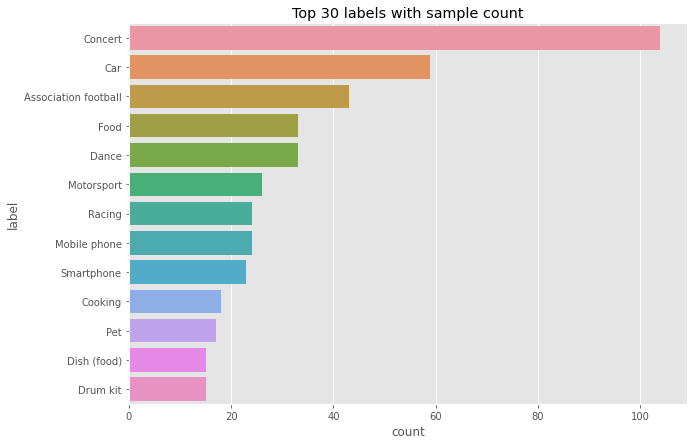

In [19]:
labels_count_dict = dict(top_n)
labels_count_df = pd.DataFrame.from_dict(labels_count_dict, orient='index').reset_index()
labels_count_df.columns = ['label', 'count']
labels_count_df['label'] = labels_count_df['label'].map(label_mapping, na_action='ignore')
TOP_labels = list(labels_count_df['label'])[:n]
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(y='label', x='count', data=labels_count_df)
plt.title('Top {} labels with sample count'.format(n))

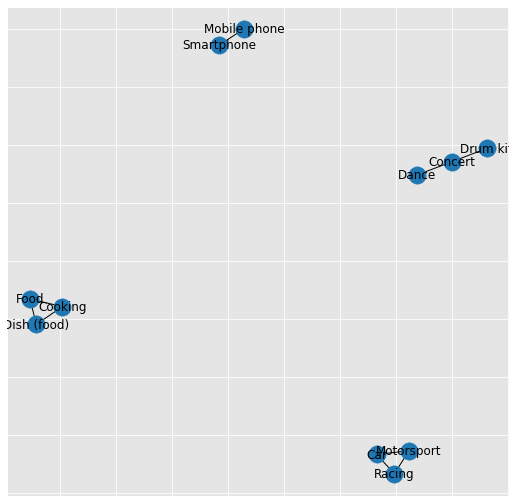

In [20]:
import networkx as nx
from itertools import combinations

G = nx.Graph()

G.clear()
for list_of_nodes in labels:
    filtered_nodes = set(list_of_nodes).intersection(set(top_n_labels) & 
                                                     set(vocabulary['Index'].unique()))  
    for node1,node2 in list(combinations(filtered_nodes,2)): 
        node1_name = label_mapping[node1]
        node2_name = label_mapping[node2]
        G.add_node(node1_name)
        G.add_node(node2_name)
        G.add_edge(node1_name, node2_name)

plt.figure(figsize=(9,9))
nx.draw_networkx(G, font_size="12")

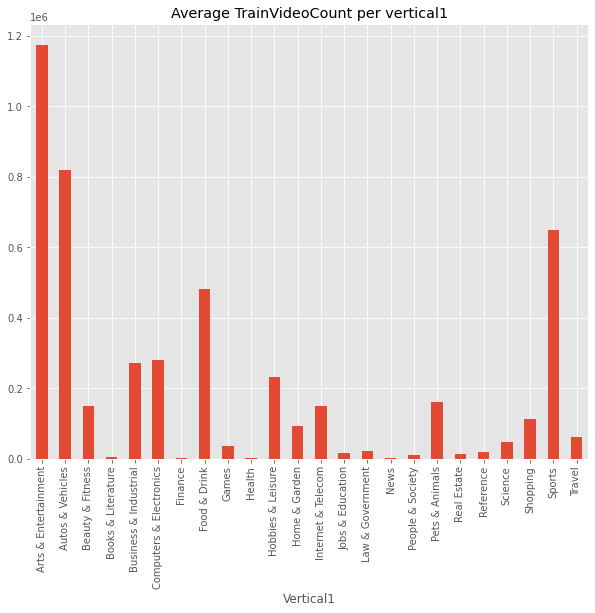

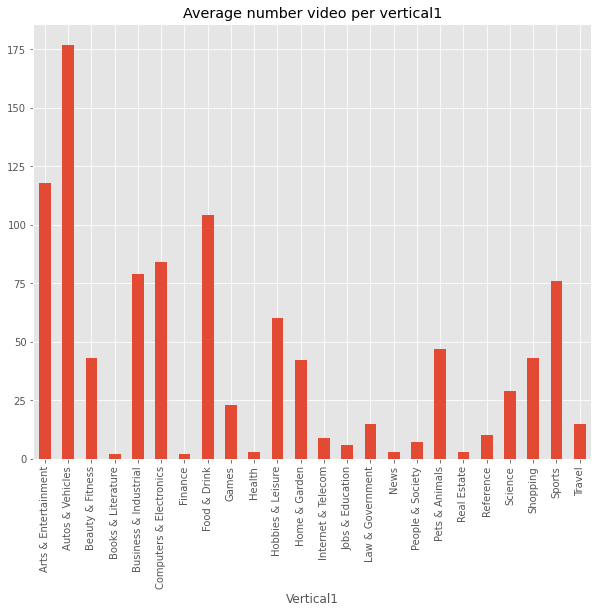

In [21]:
plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical1').TrainVideoCount.sum().plot(kind="bar")
plt.title("Average TrainVideoCount per vertical1")
plt.show()

plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical1').Index.count().plot(kind="bar")
plt.title("Average number video per vertical1")
plt.show()

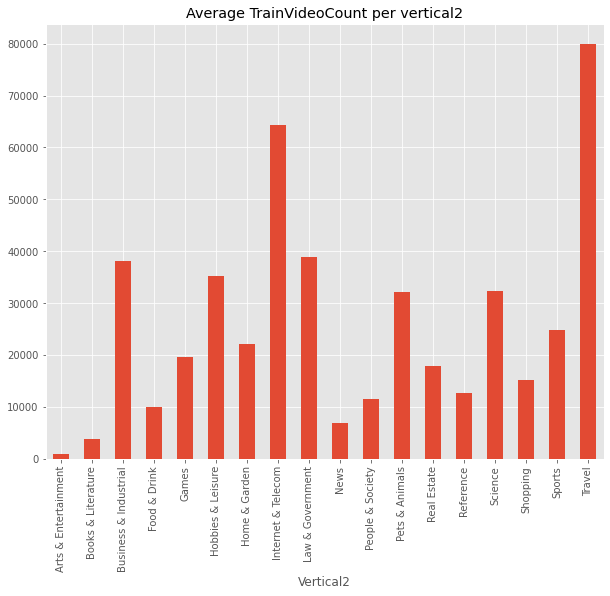

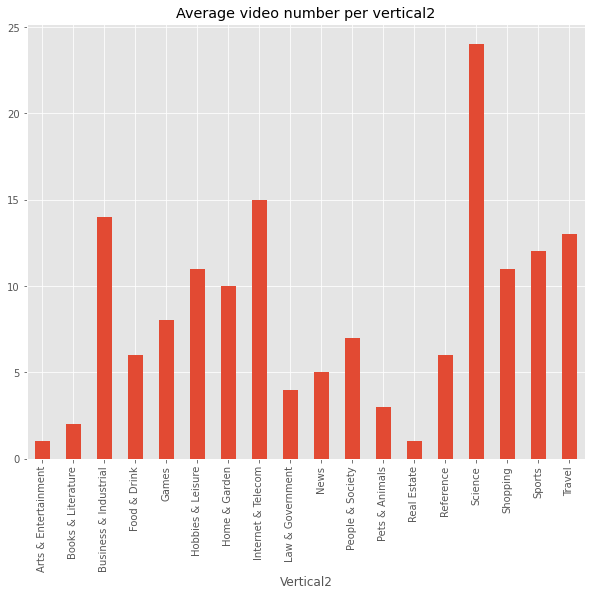

In [22]:
plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical2').TrainVideoCount.sum().plot(kind="bar")
plt.title("Average TrainVideoCount per vertical2")
plt.show()

plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical2').TrainVideoCount.count().plot(kind="bar")
plt.title("Average video number per vertical2")
plt.show()


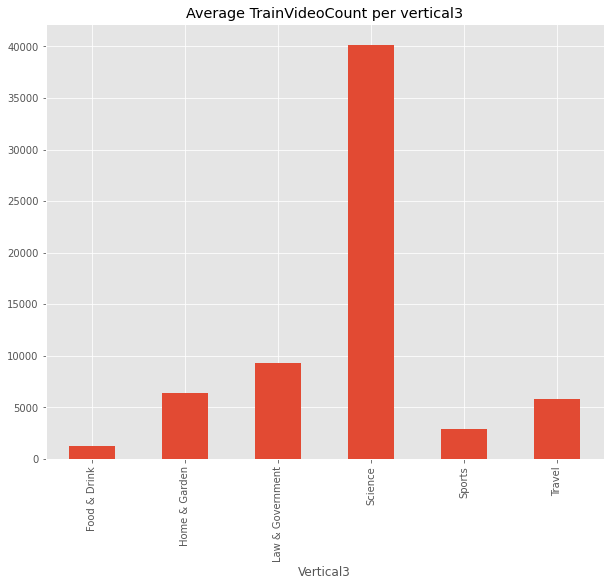

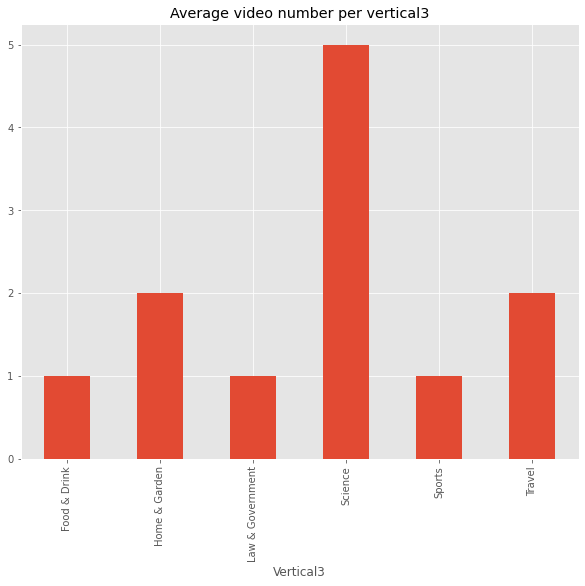

In [23]:
plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical3').TrainVideoCount.sum().plot(kind="bar")
plt.title("Average TrainVideoCount per vertical3")
plt.show()

plt.figure(figsize = (10,8))
vocabulary.groupby('Vertical3').TrainVideoCount.count().plot(kind="bar")
plt.title("Average video number per vertical3")
plt.show()

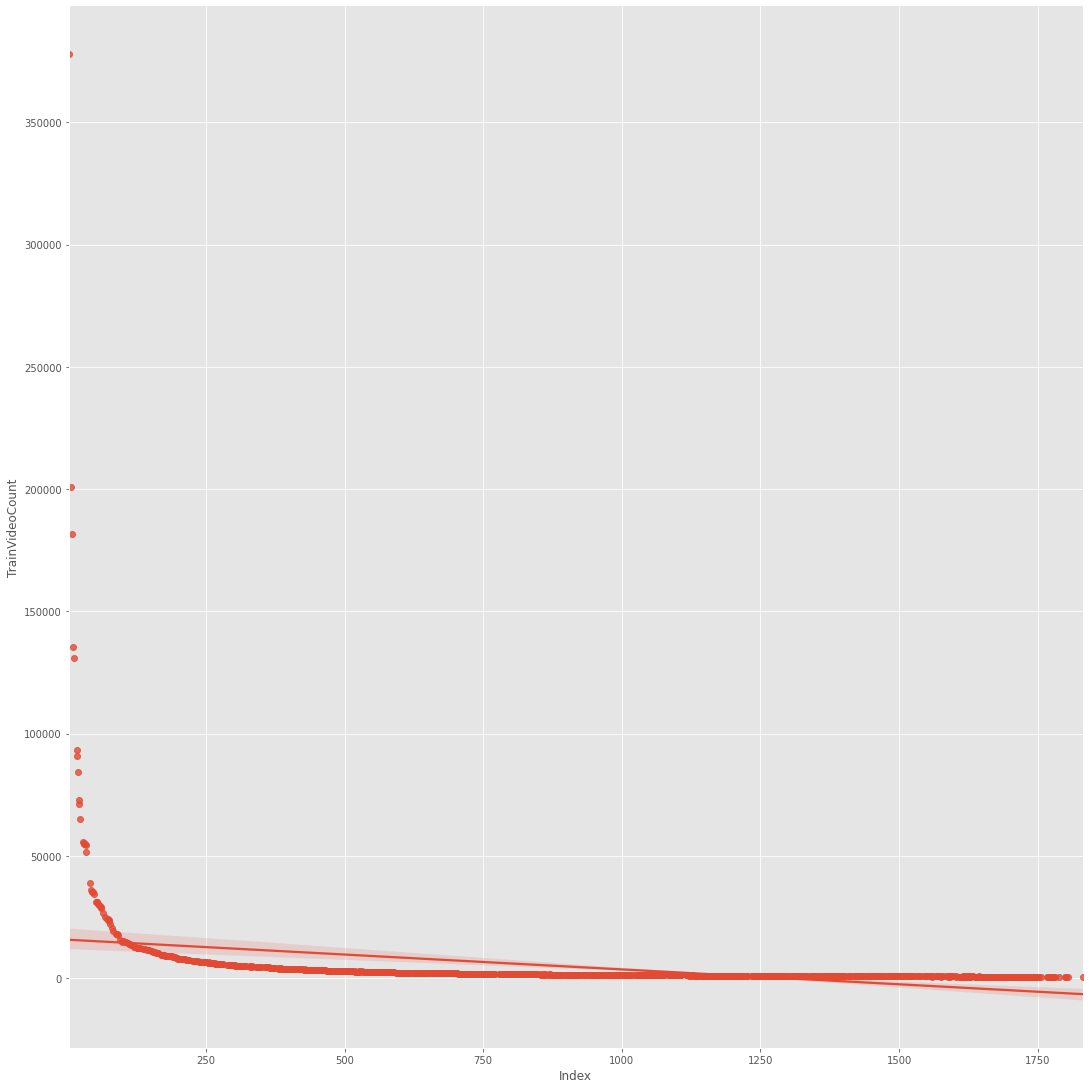

In [25]:
sns.lmplot(x='Index', y='TrainVideoCount', data=vocabulary , size=15)

In [26]:
vocabulary.groupby('Vertical1').corr()

Index  TrainVideoCount
Vertical1                                                         
Arts & Entertainment    Index            1.000000        -0.335583
                        TrainVideoCount -0.335583         1.000000
Autos & Vehicles        Index            1.000000        -0.380617
                        TrainVideoCount -0.380617         1.000000
Beauty & Fitness        Index            1.000000        -0.687573
                        TrainVideoCount -0.687573         1.000000
Books & Literature      Index            1.000000        -1.000000
                        TrainVideoCount -1.000000         1.000000
Business & Industrial   Index            1.000000        -0.643655
                        TrainVideoCount -0.643655         1.000000
Computers & Electronics Index            1.000000        -0.676121
                        TrainVideoCount -0.676121         1.000000
Finance                 Index            1.000000        -1.000000
                        TrainVideoCount -1.000000         1.000000
Food & Drink            Index            1.000000        -0.399347
                        TrainVideoCount -0.399347         1.000000
Games                   Index            1.000000        -0.780424
                        TrainVideoCount -0.780424         1.000000
Health                  Index            1.000000        -0.994288
                        TrainVideoCount -0.994288         1.000000
Hobbies & Leisure       Index            1.000000        -0.646854
                        TrainVideoCount -0.646854         1.000000
Home & Garden           Index            1.000000        -0.679861
                        TrainVideoCount -0.679861         1.000000
Internet & Telecom      Index            1.000000        -0.756289
                        TrainVideoCount -0.756289         1.000000
Jobs & Education        Index            1.000000        -0.797151
                        TrainVideoCount -0.797151         1.000000
Law & Government        Index            1.000000        -0.908027
                        TrainVideoCount -0.908027         1.000000
News                    Index            1.000000        -0.999905
                        TrainVideoCount -0.999905         1.000000
People & Society        Index            1.000000        -0.966089
                        TrainVideoCount -0.966089         1.000000
Pets & Animals          Index            1.000000        -0.447703
                        TrainVideoCount -0.447703         1.000000
Real Estate             Index            1.000000        -0.910366
                        TrainVideoCount -0.910366         1.000000
Reference               Index            1.000000        -0.801549
                        TrainVideoCount -0.801549         1.000000
Science                 Index            1.000000        -0.825646
                        TrainVideoCount -0.825646         1.000000
Shopping                Index            1.000000        -0.800188
                        TrainVideoCount -0.800188         1.000000
Sports                  Index            1.000000        -0.454807
                        TrainVideoCount -0.454807         1.000000
Travel                  Index            1.000000        -0.831157
                        TrainVideoCount -0.831157         1.000000

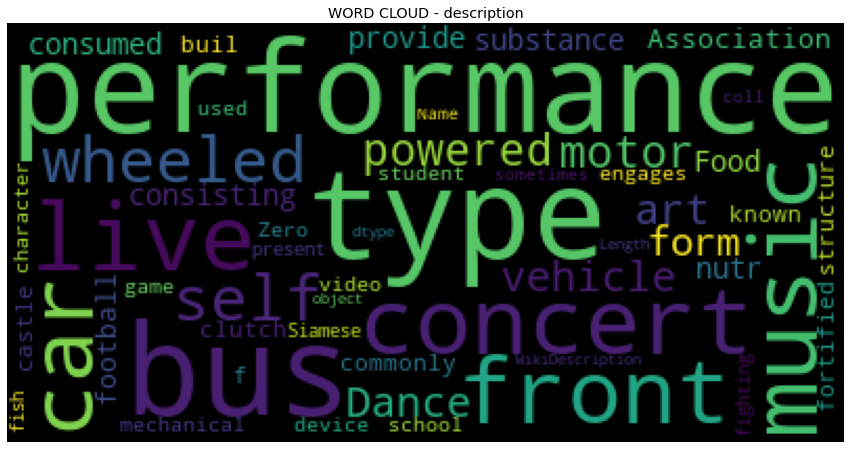

In [27]:
plt.figure(figsize = (15,15))

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=120, 
                          random_state=42
                         ).generate(str(vocabulary['WikiDescription']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - description")
plt.axis('off')
plt.show()

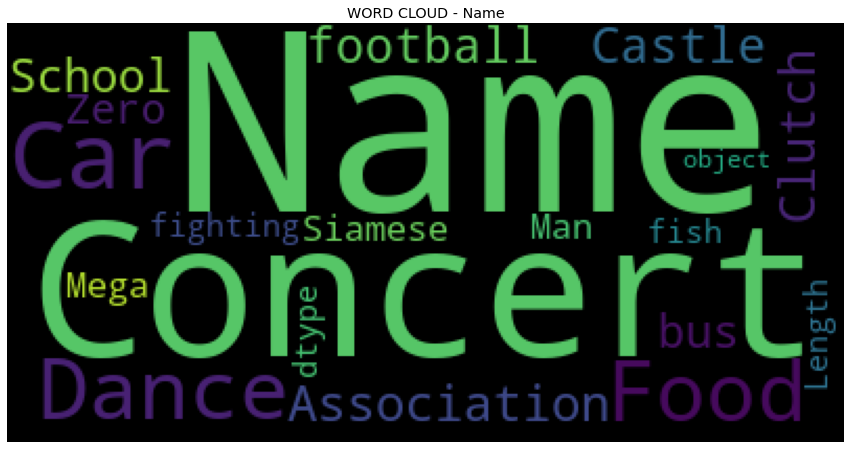

In [28]:
plt.figure(figsize = (15,15))

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=120, 
                          random_state=42
                         ).generate(str(vocabulary['Name']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - Name")
plt.axis('off')
plt.show()

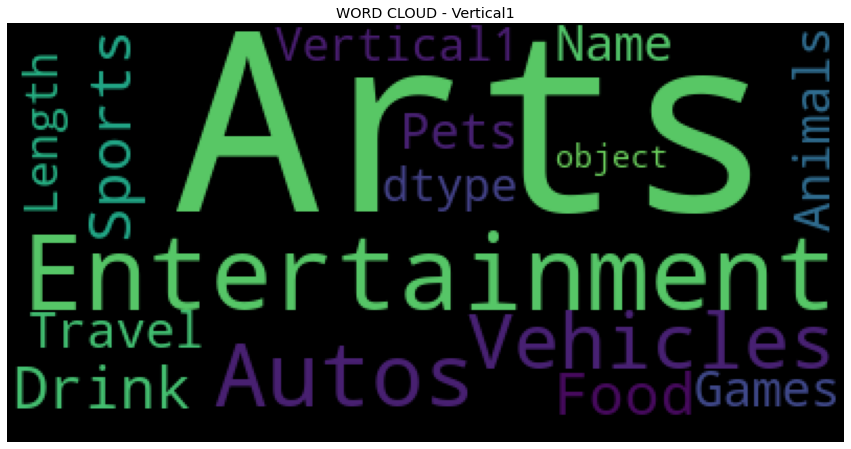

In [29]:
plt.figure(figsize = (15,15))

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='black',
                          stopwords=stopwords,
                          max_words=1000,
                          max_font_size=120, 
                          random_state=42
                         ).generate(str(vocabulary['Vertical1']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.title("WORD CLOUD - Vertical1")
plt.axis('off')
plt.show()

In [31]:
with open('/kaggle/input/youtube8m-2019/vocabulary.csv', 'r') as f:
  vocabularylist = list(csv.reader(f))

T1=[]

for l in vocabularylist:
    if l[5] != 'NaN' and l[6] !='NaN' and l[5] != '' and l[6] !='' and l[5] !=  l[6] :
        c1 = l[5]
        c2 = l[6]
        tuple = (c1, c2)
    if l[5] != 'NaN' and l[7] !='NaN' and l[5] != '' and l[7] !='' and l[5] !=  l[7] :
        c1 = l[5]
        c2 = l[7]
        tuple = (c1, c2)
    if l[6] != 'NaN' and l[7] !='NaN' and l[6] != '' and l[7] !='' and l[7] !=  l[6] :
        c1 = l[6]
        c2 = l[7]
        tuple = (c1, c2)
    T1.append(tuple)
    
edges = {k: T1.count(k) for k in set(T1)}
print ("List = ",len(edges), "elements")
edges

List =  60 elements


{('Food & Drink', 'Science'): 29,
 ('Business & Industrial', 'Travel'): 13,
 ('Business & Industrial', 'Food & Drink'): 49,
 ('Computers & Electronics', 'Games'): 26,
 ('Science', 'Shopping'): 4,
 ('Travel', 'Reference'): 3,
 ('Beauty & Fitness', 'Shopping'): 7,
 ('Autos & Vehicles', 'Sports'): 28,
 ('Business & Industrial', 'Hobbies & Leisure'): 9,
 ('Food & Drink', 'Hobbies & Leisure'): 10,
 ('Autos & Vehicles', 'People & Society'): 7,
 ('Books & Literature', 'People & Society'): 13,
 ('Business & Industrial', 'Sports'): 11,
 ('Science', 'Travel'): 6,
 ('News', 'Shopping'): 5,
 ('Sports', 'Hobbies & Leisure'): 21,
 ('Autos & Vehicles', 'Law & Government'): 19,
 ('Hobbies & Leisure', 'Sports'): 29,
 ('Home & Garden', 'Science'): 1,
 ('Business & Industrial', 'Shopping'): 21,
 ('Arts & Entertainment', 'Books & Literature'): 9,
 ('Beauty & Fitness', 'Home & Garden'): 9,
 ('People & Society', 'Shopping'): 2,
 ('Arts & Entertainment', 'Games'): 21,
 ('Vertical2', 'Vertical3'): 20,
 ('Shop

In [32]:
B = nx.DiGraph()
nodecolor=[]
for ed, weight in edges.items():
    if ed[0]!='Vertical2' and ed[0]!='Vertical3' and  ed[1]!='Vertical2' and ed[1]!='Vertical3':
        B.add_edge(ed[0], ed[1], weight=weight)
for k in B.nodes:
    if (k == "Beauty & Fitness"):
        nodecolor.append('blue')
    elif (k == "News"):
        nodecolor.append('Magenta')
    elif (k == "Food & Drink"):
        nodecolor.append('crimson')
    elif (k == "Health"):
        nodecolor.append('green')
    elif (k == "Science"):
        nodecolor.append('yellow')
    elif (k == "Business & Industrial"):
        nodecolor.append('cyan')
    elif (k == "Home & Garden"):
        nodecolor.append('darkorange')
    elif (k == "Travel"):
        nodecolor.append('slategrey')
    elif (k == "Arts & Entertainment"):
        nodecolor.append('red')
    elif (k == "Games"):
        nodecolor.append('grey')
    elif (k == "People & Society"):
        nodecolor.append('lightcoral')
    elif (k == "Shopping"):
        nodecolor.append('maroon')
    elif (k =="Computers & Electronics"):
        nodecolor.append('orangered')
    elif (k == "Hobbies & Leisure"):
        nodecolor.append('saddlebrown')
    elif (k == "Sports"):
        nodecolor.append('lawngreen')
    elif (k == "Real Estate"):
        nodecolor.append('deeppink')
    elif (k == "Finance"):
        nodecolor.append('navy')
    elif (k == "Reference"):
        nodecolor.append('royalblue')
    elif (k == "Autos & Vehicles"):
        nodecolor.append('turquoise')
    elif (k == "Internet & Telecom"):
        nodecolor.append('lime')
    elif (k == "Law & Government"):
        nodecolor.append('palegreen')
    elif (k == "Jobs & Education"):
        nodecolor.append('springgreen')
    elif (k == "Pets & Animals"):
        nodecolor.append('lightpink')
    elif (k == "Books & Literature"):
        nodecolor.append('lightpink')

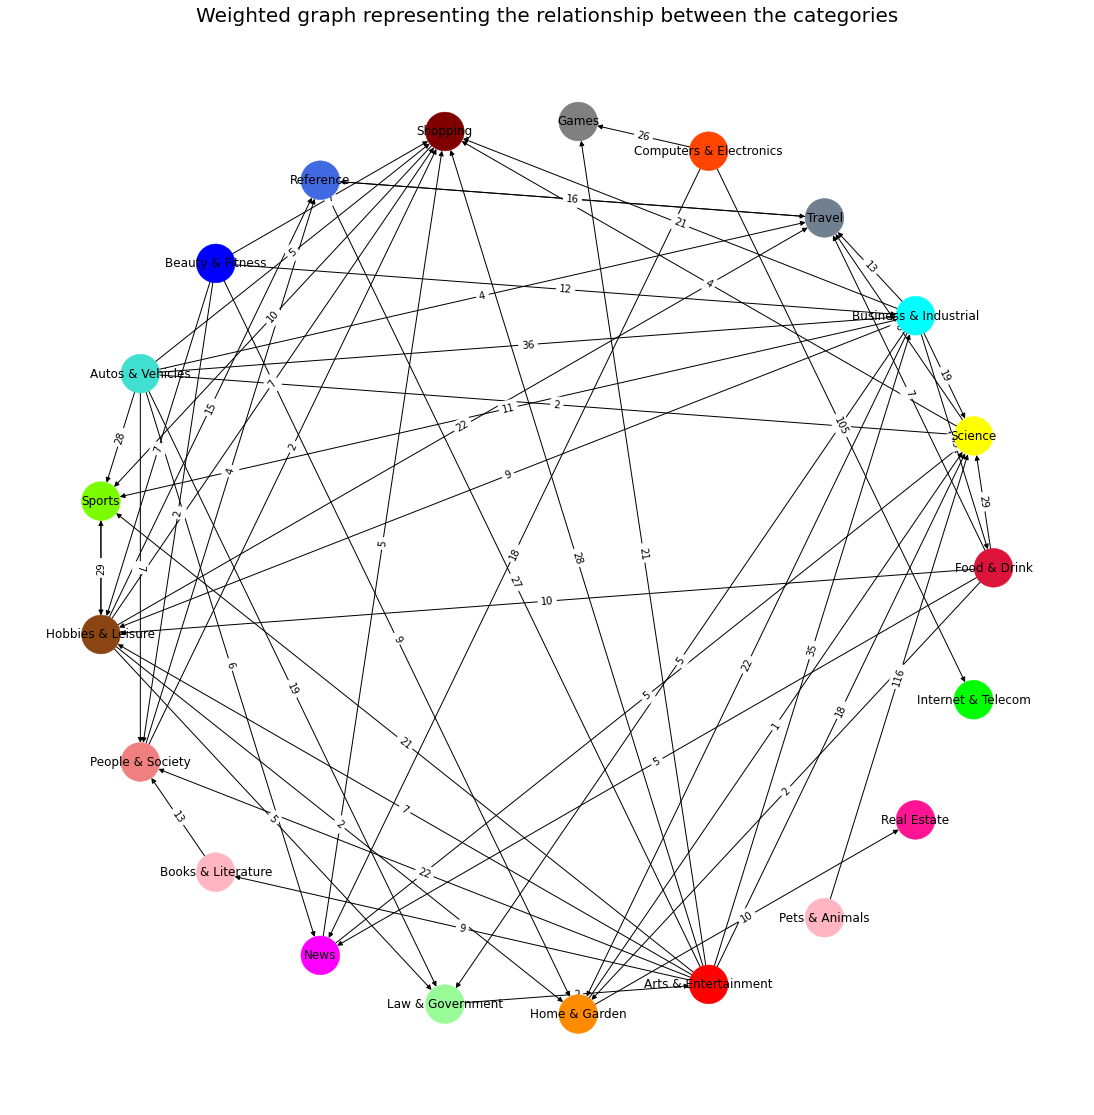

In [35]:
plt.figure(figsize = (15,15))
nx.draw(B, pos=nx.circular_layout(B), node_size=1500, with_labels=True, node_color=nodecolor)
nx.draw_networkx_edge_labels(B, pos=nx.circular_layout(B), edge_labels=nx.get_edge_attributes(B, 'weight'))
plt.title('Weighted graph representing the relationship between the categories', size=20)
plt.show()

In [33]:
# analyse
print('Quick Review')
print (20*'...',"\n")
print("number of node : %s" % B.number_of_nodes())
print("number of arcs : %s" % B.number_of_edges())

# arc entrant
indeg = 0
for n in B.in_degree():
    indeg += n[1]

# arc sortant
outdeg = 0
for n in B.in_degree():
    outdeg += n[1]

print('')
print("the number of edges pointing to the node : %s" % indeg)
print("the number of edges pointing to the outside of the node : %s" % outdeg)

# passage en graphe non orienté
G = B.to_undirected()

# min et max de degree
listmindegre = (0, 10)
listmaxdegre = (0, 0)
for n in G.degree():
    if (listmindegre[1] > n[1]):
        listmindegre = n
    if (listmaxdegre[1] < n[1]):
        listmaxdegre = n

print('')
print("The node that has the minimal degree is : ", listmindegre)
print("The node that has the maximum degree is : ", listmaxdegre)
edgdesmax=0
for ed,w in G.edges.items():
    if(w['weight']>edgdesmax):
        edgdesmax=w['weight']
        edgdescat=ed
edgdescat
print("both category ",edgdescat[0]," and ",edgdescat[1]," has the big relationship weight( w = ",edgdesmax,")")
   
# centrality
listmincentrality = (0, 10)
listmaxcentrality = (0, 0)
for n in (nx.betweenness_centrality(G)).items():
    if (listmincentrality[1] > n[1]):
        listmincentrality = n
    elif (listmaxcentrality[1] < n[1]):
        listmaxcentrality = n

print('')
print("The node that has minimal centrality is : ", listmincentrality)
print("The node that has the maximum centrality is : ", listmaxcentrality)

# normalized
listminnormalized = (0, 10)
listmaxnormalized = (0, 0)
for n in (nx.degree_centrality(G)).items():
    if (listminnormalized[1] > n[1]):
        listminnormalized = n
    elif (listmaxnormalized[1] < n[1]):
        listmaxnormalized = n

print('')
print("The node that has the minimum (normalized) degree is : ", listminnormalized)
print("The node that has the maximal (normalized) degree is: ", listmaxnormalized)

Quick Review
............................................................ 

number of node : 21
number of arcs : 59

the number of edges pointing to the node : 59
the number of edges pointing to the outside of the node : 59

The node that has the minimal degree is :  ('Pets & Animals', 1)
The node that has the maximum degree is :  ('Business & Industrial', 11)
both category  Science  and  Pets & Animals  has the big relationship weight( w =  116 )

The node that has minimal centrality is :  ('Books & Literature', 0.0)
The node that has the maximum centrality is :  ('Arts & Entertainment', 0.21447472848788637)

The node that has the minimum (normalized) degree is :  ('Pets & Animals', 0.05)
The node that has the maximal (normalized) degree is:  ('Business & Industrial', 0.55)


In [34]:
cl = list(nx.find_cliques(G))
print("estimate number of cliques %s" % nx.graph_number_of_cliques(G))
print("click on who has maximum number %s" % nx.graph_clique_number(G))
print('')

print(">> possible cases of clique:\n")
for cl in nx.find_cliques(G):
    if len(cl)==2 or len(cl)==3:
        print(cl)

estimate number of cliques 28
click on who has maximum number 5

>> possible cases of clique:

['Internet & Telecom', 'Computers & Electronics']
['News', 'Science', 'Food & Drink']
['News', 'Computers & Electronics']
['Books & Literature', 'People & Society', 'Arts & Entertainment']
['Reference', 'People & Society', 'Arts & Entertainment']
['Reference', 'Hobbies & Leisure', 'Travel']
['Reference', 'Hobbies & Leisure', 'Arts & Entertainment']
['Pets & Animals', 'Science']
['Business & Industrial', 'Autos & Vehicles', 'Law & Government']
['Computers & Electronics', 'Games']
['People & Society', 'Shopping', 'Autos & Vehicles']
['People & Society', 'Shopping', 'Beauty & Fitness']
['People & Society', 'Shopping', 'Arts & Entertainment']
['Real Estate', 'Home & Garden']
['Games', 'Arts & Entertainment']


In [36]:
pathlengths = []

for v in G.nodes():
    spl = nx.single_source_shortest_path_length(G, v)
    for p in spl.values():
        pathlengths.append(p)
print("average of the shortest paths %s" % round((sum(pathlengths) / len(pathlengths)), 3))

print('')

print("density : %s" % round(nx.density(G), 3))
print("diameter :", nx.diameter(G.subgraph(max(nx.connected_components(G), key=len))))

# eccentricity
listmineccentricity = (0, 10)
listmaxeccentricity = (0, 0)
for n in (nx.eccentricity(G.subgraph(max(nx.connected_components(G), key=len)))).items():
    if (listmineccentricity[1] > n[1]):
        listmineccentricity = n
    elif (listmaxeccentricity[1] < n[1]):
        listmaxeccentricity = n

print('')
print("The node that has the minimal eccentricity is : ", listmineccentricity)
print("The node that has the maximum eccentricity is : ", listmaxeccentricity)
print('')

print("center : %s" % nx.center(G.subgraph(max(nx.connected_components(G), key=len))))
print("periphery : %s" % nx.periphery(G.subgraph(max(nx.connected_components(G), key=len))))

average of the shortest paths 1.991

density : 0.271
diameter : 5

The node that has the minimal eccentricity is :  ('Food & Drink', 3)
The node that has the maximum eccentricity is :  ('Real Estate', 5)

center : ['Food & Drink', 'Science', 'Shopping', 'Autos & Vehicles', 'News', 'Arts & Entertainment']
periphery : ['Real Estate', 'Internet & Telecom']


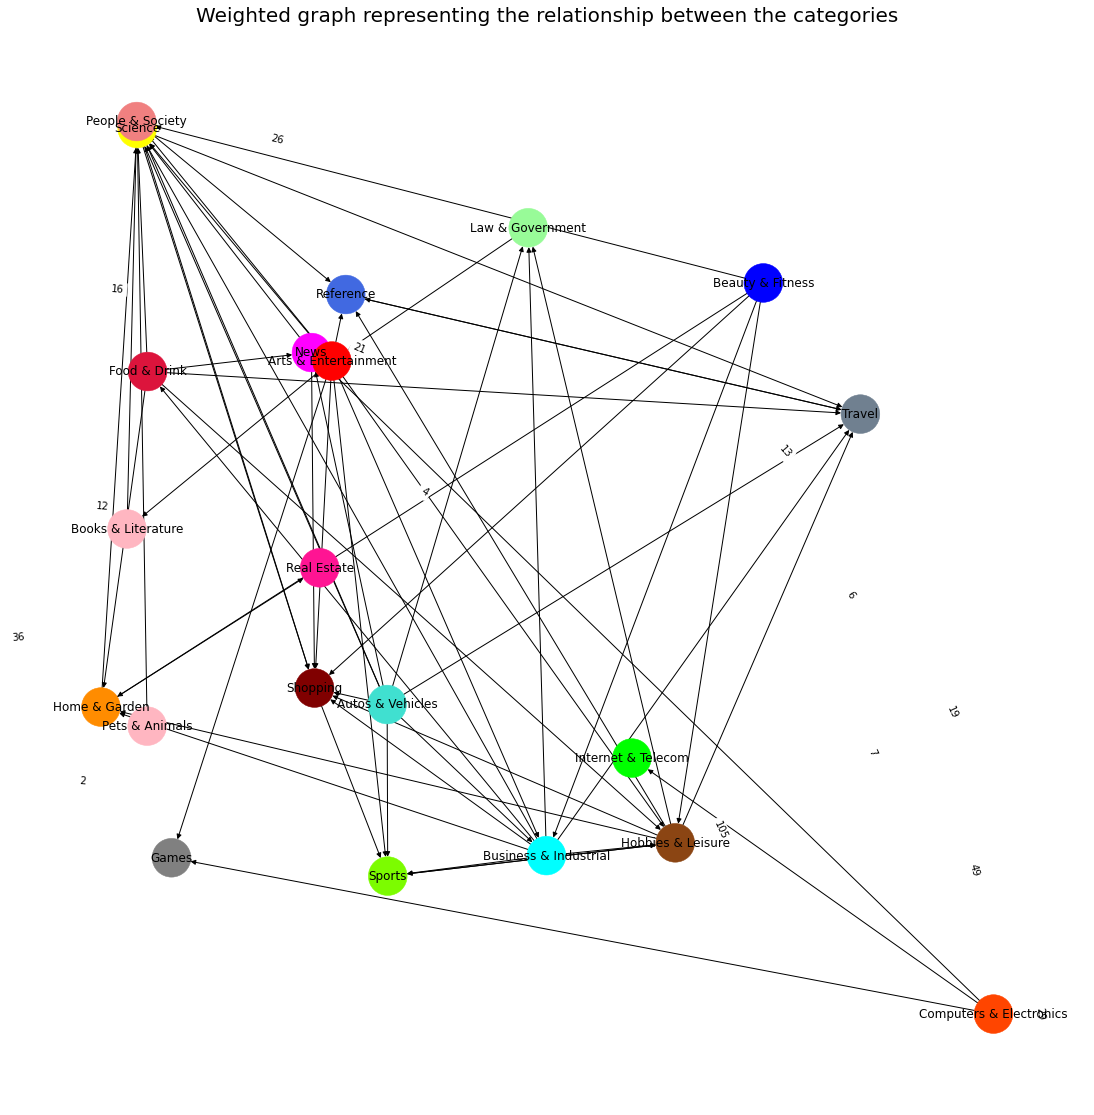

In [37]:
plt.figure(figsize = (15,15))
nx.draw_random(B,  node_size=1500, with_labels=True, node_color=nodecolor)
nx.draw_networkx_edge_labels(B, pos=nx.circular_layout(B), edge_labels=nx.get_edge_attributes(B, 'weight'))
plt.title('Weighted graph representing the relationship between the categories', size=20)
plt.show()